In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange

## Lyapunov Exponents of the Mandelbrot Set

The Mandelbrot set is obtained by using the function $f(z) = z^2 + c$ as a map, where $z,c \in \mathbb{C}$. To iterate this map, we calculate $$z_{n+1} = z_{n} + c$$

In particular, this set is defined as the numbers $c$ such that the map does not diverge for $z_0=0$. To talk about the stability of different trajectories induced by this map, we introduce the Lyapunov exponent $\lambda$. Conceptually, we can think of two trajectories in phase space that are initially separted by some $\delta \mathbf{Z}_0$. The separation at some later time $t$, is then given by:

$$|\delta \mathbf{Z}(t)| \approx e^{\lambda t}\delta |\mathbf{Z}_0|$$

Thus, for positive lambda we have exponentially diverging trajectories, and for negative lambda, we have stable trajectories. For a discrete map $x_{n+1} = f(x_n)$, the Lyapunov exponent is given by:

$$\lambda = \lim_{n \to \infty} \frac{1}{n} \sum_i^{n-1} \ln |f'(x_i)|$$

For the Mandelbrot set, this is:

$$\lambda = \lim_{n \to \infty} \frac{1}{n} \sum_i^{n-1} \ln |2 z_i|$$

This is what we calculate below. Note that, by definition of the Mandelbrot set, for the first iteration $z=0$. This means the natural logarithm tends to negative infinity. However, this is really just an issue with defining a derivate for a discrete map, so we disregard this term. In addition, for some values of $c$, the value of $z$ and thereby $\lambda$ will diverge. This leads to either `NaN` or `inf` values. To avoid this issue, we set a threshold to regulate $\lambda$. Since we need to divide by the number of iterations to calculate $\lambda$ this means we also need to keep track of during which iteration the value surpassed the threshold. This is done by only updating entries in a counter array that have not diverged. 

In [2]:
def compute_lyapunov_exponents(x_range, y_range, Npts=1000, max_iter=1000, threshold=1e100):
    '''
    Calculates the lyapunov exponents of the Mandelbrot set for patch of the complex numbers. 
    
    Args
        x_range (array-like): limits of the real axis. 
        y_range (array-like): limits of the imaginary axis. 
        Npts (int): number of points on each axis. The grid representing a patch of the complex numbers is then Npts * Npts in size. 
        max_iter (int): the maximum number of iterations to compute the madelbrot set and lyapunov exponent. 
        threshold (float): for some initial values, the lyapunov exponent will diverge. This sets a ceiling on our lyapunov exponent to avoid infinites and NaN values. 
        
    Returns
        lyapunov (ndarray of size Npts * Npts): An grid of floats, representing the lyapunov exponent of the Mandelbrot set for different points on the complex plane. 
    '''
    
    # initialize a patch of the complex plane
    real_axis = np.linspace(*x_range, Npts)
    imaginary_axis = np.linspace(*y_range, Npts)
    real_grid, imaginary_grid = np.meshgrid(real_axis, imaginary_axis)
    complex_plane = real_grid.T + imaginary_grid.T * 1j
    
    z = np.zeros(complex_plane.shape, dtype=complex)
    dz = np.ones(complex_plane.shape, dtype=complex)
    lyapunov = np.zeros(complex_plane.shape, dtype=float)
    
    counter = np.zeros(complex_plane.shape, dtype=int) # when an element in z breaches our threshold, we will store what iteration this happened at so that we can compute the lyapunov exponent
    diverging_values_cut = np.full(complex_plane.shape, True) # use a boolean array to track which elements of our array have not diverged
    
    
    for i in range(max_iter):
    
        z = np.where(np.abs(z) > threshold, threshold, z) # if a value in z is above the threshold, limit it to the threshold. 
        
        dz = 2 * z 
        z = z**2 + complex_plane   
    
        dz = np.where(np.abs(dz) > threshold, threshold, dz) # if a value in dz is above the threshold, limit it to the threshold. 
        
        if i > 0:
            lyapunov[diverging_values_cut] += np.log(np.abs(dz[diverging_values_cut]))
        counter[diverging_values_cut] += 1 # update counter for values that have not diverged
        
        diverging_values_cut = np.abs(z) < threshold # update our boolean array to track which elements have not diverged
        
    lyapunov = lyapunov / counter
    
    return lyapunov


In [3]:
x_range = [-2, 1]
y_range = [-1.5, 1.5]
lyapunov = compute_lyapunov_exponents(x_range, y_range)

Text(0, 0.5, 'Im(z)')

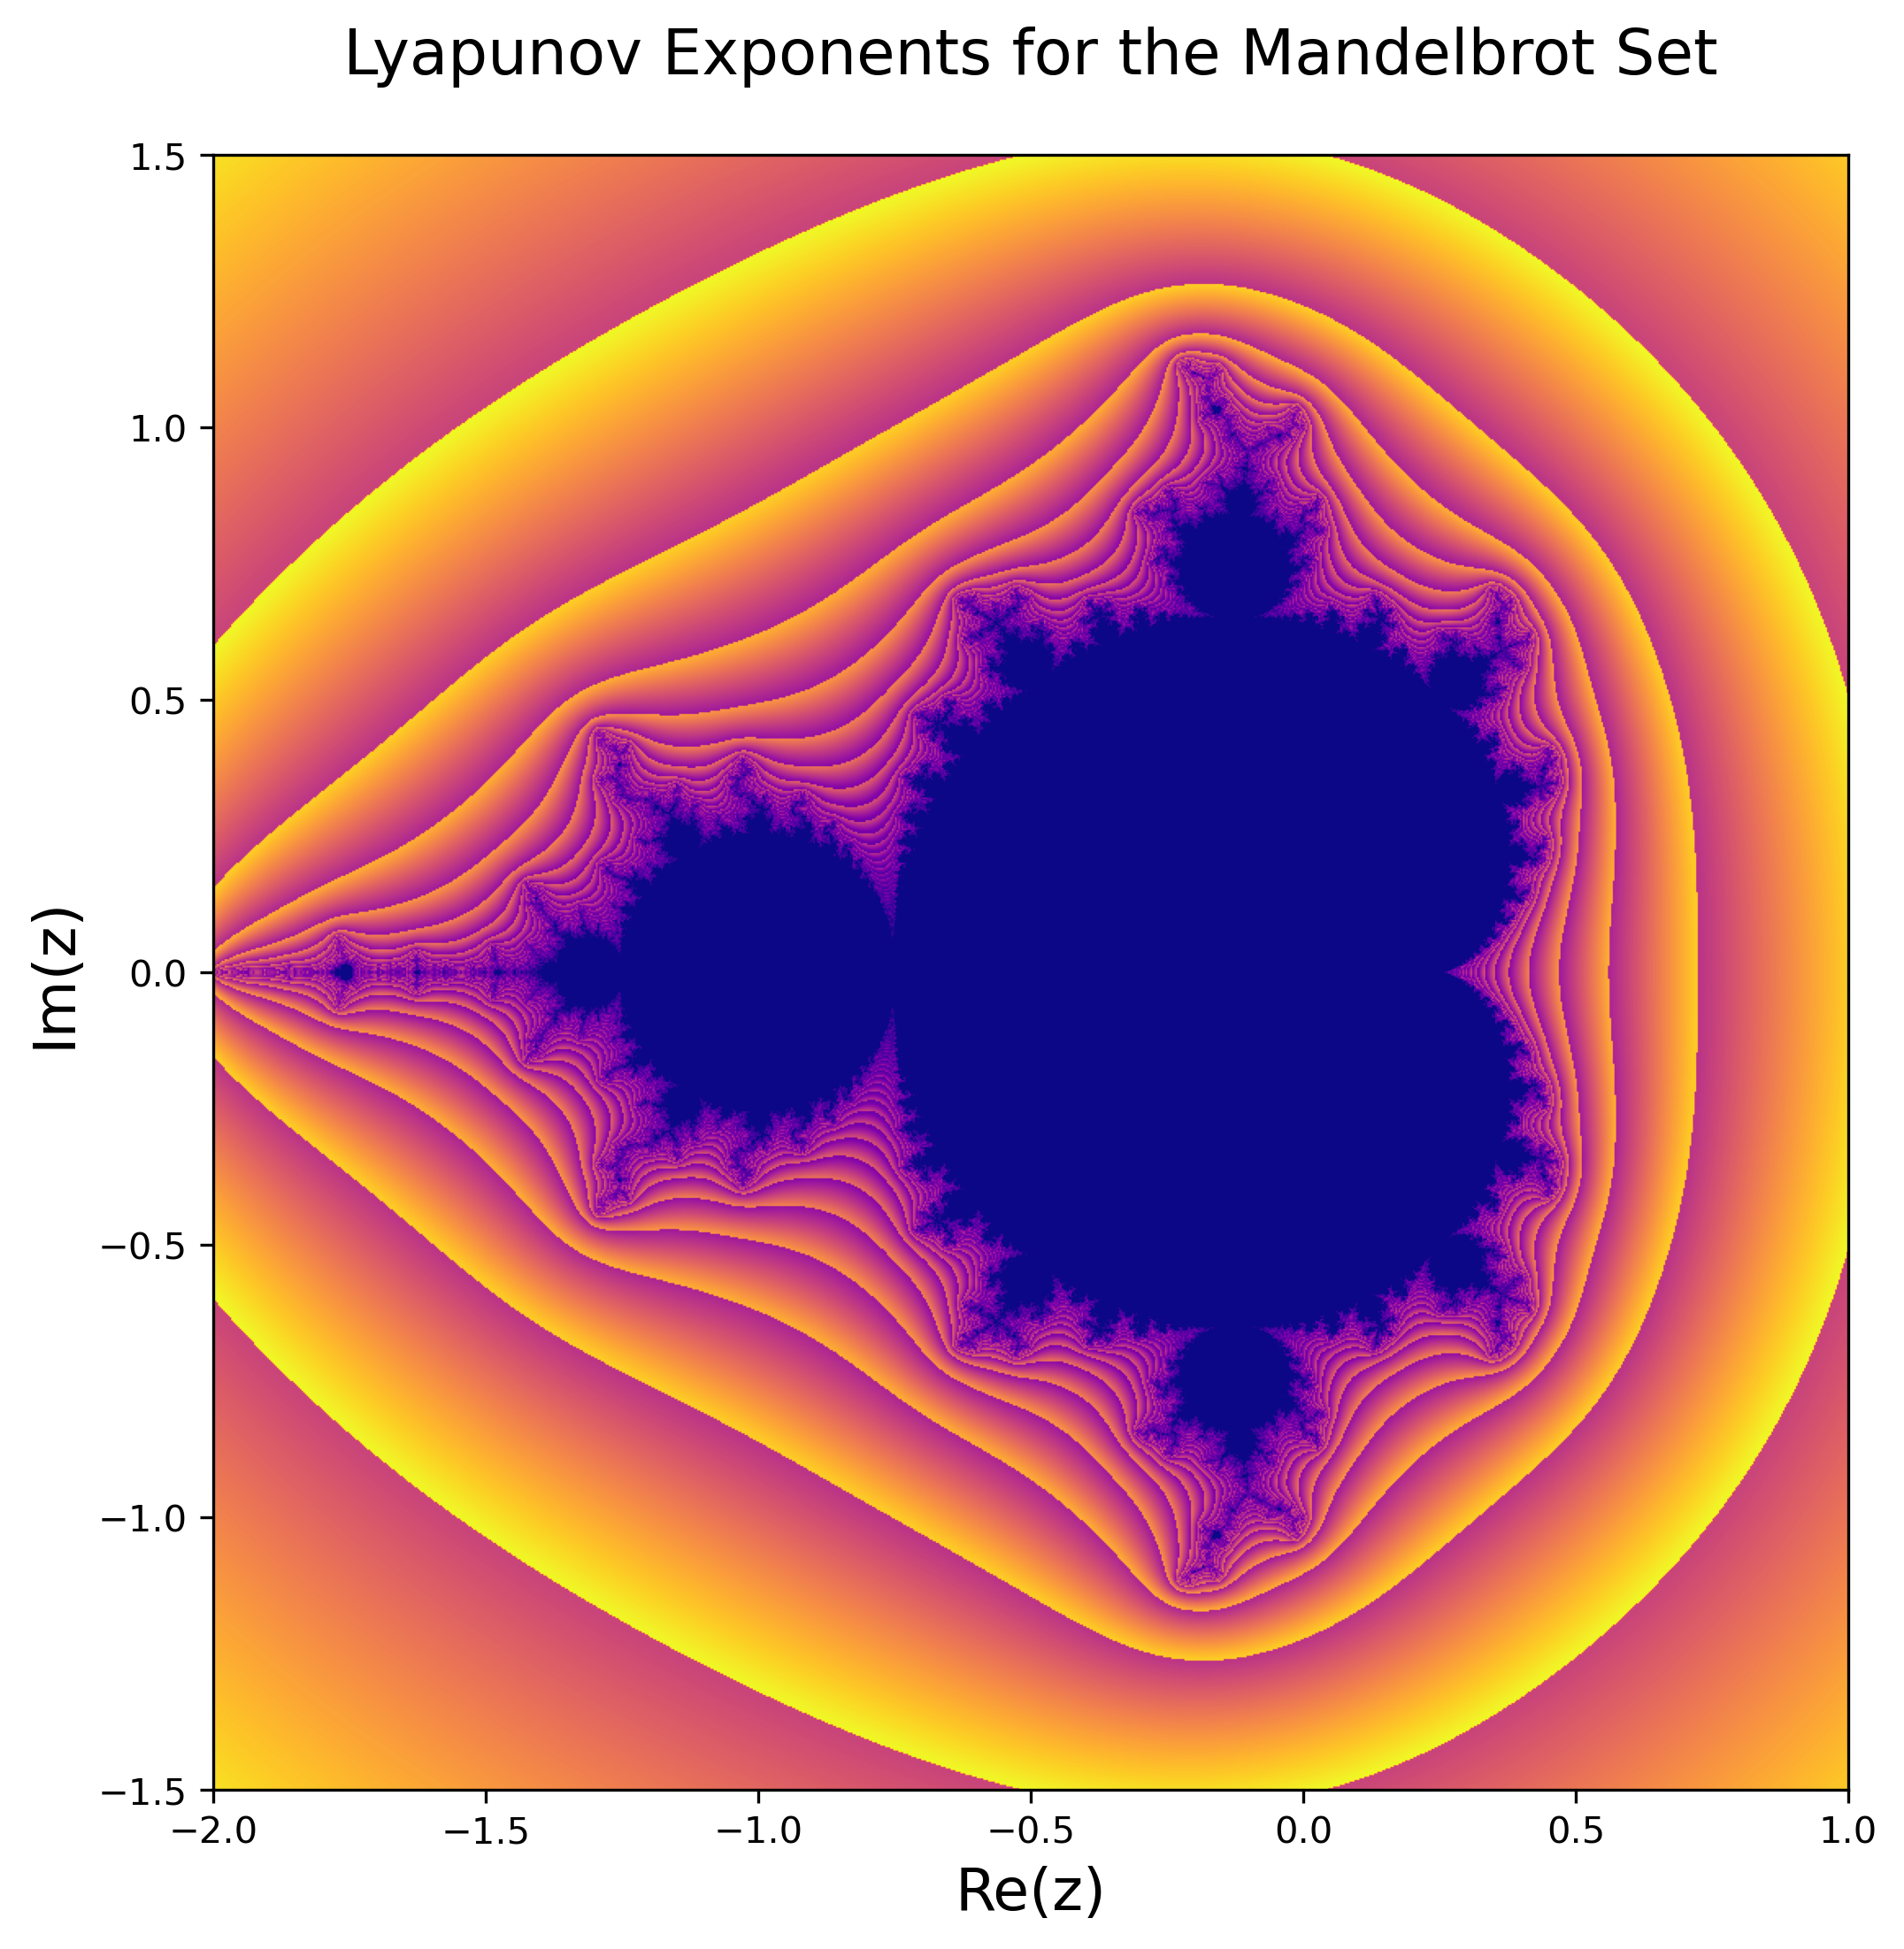

In [4]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=300)

im = ax.imshow(lyapunov.T, 
          extent=[*x_range, *y_range], 
          cmap='plasma', 
          origin='lower', 
          vmin=-lyapunov.min(), vmax=lyapunov.max())

ax.set_title('Lyapunov Exponents for the Mandelbrot Set', fontsize=17, pad=22)
ax.set_xlabel('Re(z)', fontsize=16)
ax.set_ylabel('Im(z)', fontsize=16)